## Lab 2

### Part 3. Poetry generation

Let's try to generate some poetry using RNNs. 

You have several choices here: 

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [1]:
import string
import os
import torch, torch.nn as nn

### Data loading: Shakespeare

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`). Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [2]:
if not os.path.exists('sonnets.txt'):
    !wget https://raw.githubusercontent.com/girafe-ai/ml-course/22f_basic/homeworks_basic/lab02_deep_learning/sonnets.txt

with open('sonnets.txt', 'r') as iofile:
    text = iofile.readlines()
    
TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START : TEXT_END]
assert len(text) == 2616

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [3]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here

assert len(text) == 100225, 'Are you sure you have concatenated all the strings?'
assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
print('OK!')

AssertionError: Are you sure you have concatenated all the strings?

### Data loading: "Евгений Онегин"


In [415]:
#wget https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt
    
with open('onegin.txt', 'r', encoding='utf-8') as iofile:
    text = iofile.readlines()
    
text = [x.replace('\t\t', '') for x in text]

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [416]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here

all_text = "".join(text)
out = all_text.lower()

Put all the characters, that you've seen in the text, into variable `tokens`.

In [417]:
tokens = sorted(set(out))
num_tokens = len(tokens)
seq_length = 100
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('{} device is available'.format(device))

cuda device is available


Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [418]:
# dict <index>:<char>
# Your great code here
idx_to_token = {i : tokens[i] for i in range(len(tokens))}
# dict <char>:<index>
# Your great code here
token_to_idx = {tokens[i] : i for i in range(len(tokens))}

In [419]:
text_encoded = [token_to_idx[x] for x in out]

In [420]:
import numpy as np
batch_size = 256
start_column = np.zeros((batch_size, 1), dtype=int)

def generate_chunk():
    global text_encoded, start_column, batch_size, seq_length

    start_index = np.random.randint(0, len(text_encoded) - batch_size*seq_length - 1)
    data = np.array(text_encoded[start_index:start_index + batch_size*seq_length]).reshape((batch_size, -1))
    yield np.hstack((start_column, data))

*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [421]:
import torch, torch.nn as nn

In [422]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()        
        self.encoder = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers)
        self.decoder = nn.Linear(hidden_size, output_size)
    
    def forward(self, input, hidden):
        input = self.encoder(input.view(1, -1))
        output, hidden = self.gru(input.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))
        return output, hidden

In [423]:
model = RNN(num_tokens, seq_length, num_tokens, 1).to(device)
optim = torch.optim.Adam(model.parameters(), lr=0.003)
criterion = nn.functional.cross_entropy
loss_hist = []
def train(input, target):
    hidden = torch.zeros(1, 1, seq_length)
    model.zero_grad()
    loss = 0
    for c in range(len(input)):
        output, hidden = model.forward(input[c], hidden.to(device))
        loss += criterion(output.to(device), torch.LongTensor(target[c].view(1).to("cpu")).to(device))
    loss_hist.append(loss / len(input))
    loss.backward()
    optim.step()

In [424]:
import time
n_epochs = 10
loss_epoch_hist = []
for ep in range(n_epochs):
    start = time.time()
    i = next(generate_chunk())
    inp = i[:, :-1]
    target = i[:, 1:]
    for ind in range(len(i)):
        train(torch.tensor(inp[ind]).to(device), torch.LongTensor(target[ind]).to(device))
    loss_epoch_hist.append(loss_hist[len(loss_hist)-1])
    end = time.time()
    print("Потрачено на {0} эпоху: {1}".format(ep, end - start))

Потрачено на 0 эпоху: 41.14121747016907
Потрачено на 1 эпоху: 46.8232147693634
Потрачено на 2 эпоху: 41.28014039993286
Потрачено на 3 эпоху: 44.79228639602661
Потрачено на 4 эпоху: 36.68607783317566
Потрачено на 5 эпоху: 45.56701350212097
Потрачено на 6 эпоху: 45.93218731880188
Потрачено на 7 эпоху: 36.49812960624695
Потрачено на 8 эпоху: 39.19425058364868
Потрачено на 9 эпоху: 37.84469127655029


Plot the loss function (axis X: number of epochs, axis Y: loss function).

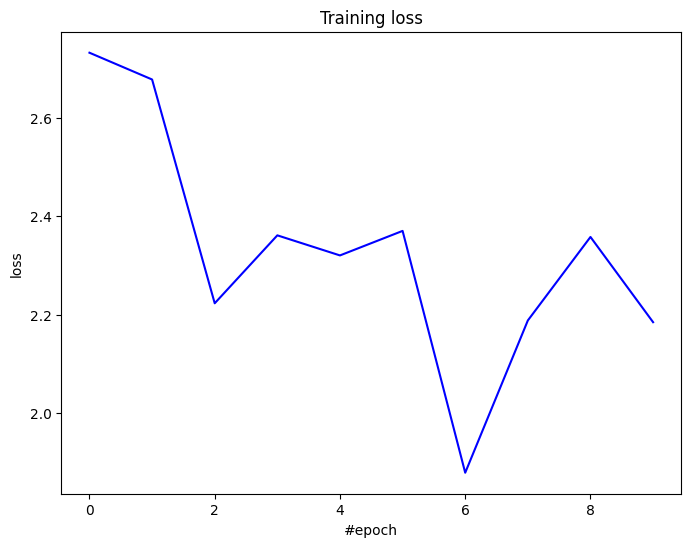

In [425]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))        
plt.title("Training loss")
plt.xlabel("#epoch")
plt.ylabel("loss")
plt.plot(torch.tensor(loss_epoch_hist).cpu(), 'b')
plt.show()

In [426]:
def generate_sample(char_rnn, seed_phrase=' привет', max_length=seq_length, temperature=1.0):
    '''
    ### Disclaimer: this is an example function for text generation.
    ### You can either adapt it in your code or create your own function
    
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs, 
        smaller temperature converges to the single most likely output.
        
    Be careful with the model output. This model waits logits (not probabilities/log-probabilities)
    of the next symbol.
    '''
    
    x_sequence = [token_to_idx[token] for token in seed_phrase]
    x_sequence = torch.tensor(x_sequence, dtype=torch.int64).to(device)
    result = []
    hidden = torch.zeros(1, 1, 100).to(device)
    for ind in range(len(seed_phrase) - 1):
        temp, hidden = char_rnn(x_sequence[ind], hidden)
    first_input = x_sequence[-1]
    for ind in range(max_length - x_sequence.shape[0] + 1):
        next_ch, hidden = char_rnn(first_input, hidden)
        predicted = next_ch.view(-1).div(temperature).exp()
        predicted_char = torch.multinomial(predicted, 1)[0]
        x_sequence = torch.cat((x_sequence, predicted_char.view(-1)))
        first_input = predicted_char
    return ''.join([tokens[ix] for ix in x_sequence.cpu().data.numpy()])

In [427]:
# An example of generated text.
print(generate_sample(model, max_length=500, temperature=0.2))

 привет,
в ней в старине не веренья,
и в не в сердце старей в том в ней в отом
и в ней деле в онегин ней
поставить молчала в страть,
и в сердце в страстель в головой вот онегин старий
друг могла старий в молчала
должны в долны и в ней в ней
деревно не головенья,
и в ней стражденья в онегин странной
под в ней страдит стражда в ней
друзья моей не сталось,
и в нем и в ней страдит от вот,
в не в молчал его в столет,
и в мой в страши молчаль молчала воленье
где в онеги в ней в мой вот вот ней
друг мол


### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

In [428]:
text_encoded_onehot = torch.zeros(len(text_encoded), 83)
for i in range(len(text_encoded)):
    text_encoded_onehot[i][text_encoded[i]] = 1

In [429]:
start_column = np.zeros((batch_size, 1, 83), dtype=np.float32)
def generate_chunk():
    global text_encoded_onehot, start_column, batch_size, seq_length
    start_index = np.random.randint(0, len(text_encoded_onehot) - batch_size*seq_length - 1)
    data = np.array(text_encoded_onehot[start_index:start_index + batch_size*seq_length]).reshape((batch_size, seq_length, 83))
    yield np.hstack((start_column, data))

In [475]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, n_layers)
        self.decoder = nn.Linear(hidden_size, output_size)
        self.drop = nn.Dropout(0.2)
    
    def forward(self, input, hidden):
        output, hidden = self.lstm(input.view(1, -1), hidden)
        output = self.drop(output)
        output = self.decoder(output.view(1, -1))
        return output, hidden

In [476]:
model = LSTM(num_tokens, seq_length, num_tokens, 1).to(device)
optim = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.functional.cross_entropy
loss_hist_lstm = []
def train(input, target):
    model.zero_grad()
    hidden = torch.randn(1, seq_length).to(device)
    second = torch.randn(1, seq_length).to(device)
    tuple_tensors = (hidden, second)
    #hidden = torch.stack([hidden, second], dim=0).to(device)
    loss = 0
    for c in range(len(input) - 1):
        output, hidden = model.forward(input[c], tuple_tensors)
        loss += criterion(output.view(83).to(device), target[c].view(83).to("cpu").argmax(dim=0).to(device))
    loss_hist_lstm.append(loss / len(input))
    loss.backward()
    optim.step()

In [477]:
import time
n_epochs = 7
loss_epoch_hist_lstm = []
for ep in range(n_epochs):
    start = time.time()
    i = next(generate_chunk())
    inp = i[:, :-1]
    target = i[:, 1:]
    for ind in range(len(i)):
        train(torch.tensor(inp[ind]).to(device), torch.LongTensor(target[ind]).to(device))
    loss_epoch_hist_lstm.append(loss_hist_lstm[len(loss_hist_lstm)-1])
    end = time.time()
    print("Потрачено на {0} эпоху: {1}".format(ep, end - start))

Потрачено на 0 эпоху: 77.73361802101135
Потрачено на 1 эпоху: 36.63987183570862
Потрачено на 2 эпоху: 37.144590616226196
Потрачено на 3 эпоху: 35.76219415664673
Потрачено на 4 эпоху: 38.52827739715576
Потрачено на 5 эпоху: 36.33201742172241
Потрачено на 6 эпоху: 38.48348069190979


Plot the loss function of the number of epochs. Does the final loss become better?

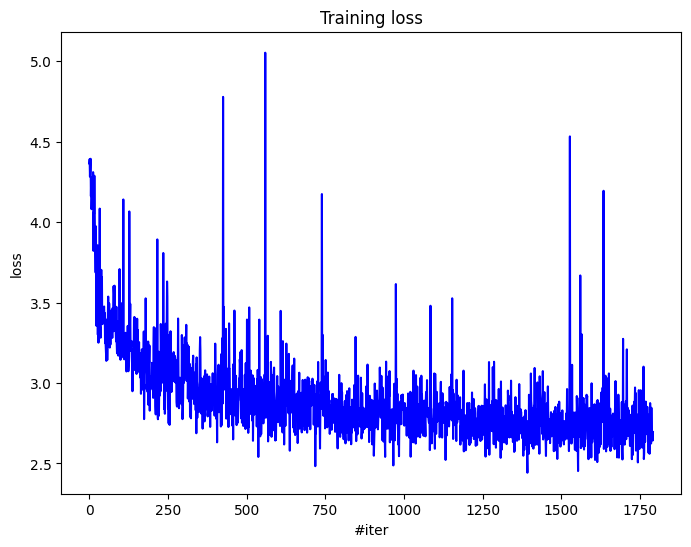

In [489]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))        
plt.title("Training loss")
plt.xlabel("#iter")
plt.ylabel("loss")
plt.plot(torch.tensor(loss_hist_lstm).cpu(), 'b')
plt.show()

In [552]:
def generate_sample(char_rnn, seed_phrase=' привет', max_length=seq_length, temperature=1.0):
    '''
    ### Disclaimer: this is an example function for text generation.
    ### You can either adapt it in your code or create your own function
    
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs, 
        smaller temperature converges to the single most likely output.
        
    Be careful with the model output. This model waits logits (not probabilities/log-probabilities)
    of the next symbol.
    '''
    model.eval()
    x_sequence = [token_to_idx[token] for token in seed_phrase]
    x_sequence = torch.tensor(x_sequence, dtype=torch.int64).to(device)
    result = []
    hidden = torch.zeros(1, 100).to(device)
    second = torch.zeros(1, 100).to(device)
    hidden = (hidden, second)
    for ind in range(len(seed_phrase) - 1):
        inp = torch.zeros(83).to(device)
        inp[x_sequence[ind]] = 1
        inp, hidden = char_rnn(inp, hidden)
    first_input = x_sequence[-1]
    inp = torch.zeros(83).to(device)
    inp[x_sequence[-1]] = 1
    for ind in range(max_length - x_sequence.shape[0] + 1):
        next_ch, hidden = char_rnn(inp, hidden)
        predicted = next_ch.view(83).div(temperature).exp()
        predicted_char = torch.multinomial(predicted, 1)[0]
        x_sequence = torch.cat((x_sequence, predicted_char.view(-1)))
        inp = torch.zeros(83).to(device)
        inp[predicted_char] = 1
    return ''.join([tokens[ix] for ix in x_sequence.cpu().data.numpy()])

Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [553]:
for i in [0.1, 0.2, 0.5, 1.0, 2.0]:
    print("temperature: {0} : {1}".format(i, generate_sample(model, max_length=500, temperature=i)))

temperature: 0.1 :  приветовово стала ста ста сто ста стово ста сто ста ста сто ста ста по ста ста сто ста сто сто стала ста ста ста стово ста ста сто ста ста ста ста ста ста по ста сто ста ста ста сто сто ста ста сто сто ста стово ста ста сто ста ста ста ста ста ста ста ста сто ста ста ста ста ста ста ста сто ста ста ста сто ста ста во ста ста сто по ста ста ста ста сто ста ста сто сто ста сто ста ста сть сто ста ста сто ста ста повово ста ста ста пово ста сто ста сто ста по ста сто ста ста ста сто стово ста ста с
temperature: 0.2 :  привет ный поненый ста по сталена сто по м вово ста во ста стой сторала сто ста по ста стала ста стовый ста сть пово ста ста ста ста стовы стани ста ста стоный ста сто стововоный стора стора стой ста сть сто ста ста ста стала по сто стало сть сто ных стова ста вовый ста воре стой во сть ом по сть по ста ста сть стала сть ста стово сто ста стововона сталали ный сто во сть стовово пова ста ста ста ста сть стоне ста стова статала стона сть ный ста во сть ста

Честно говоря, получить более вразумительные результаты почему-то не получилось и loss всегда был около 2.5, были опробованы различные комбинации слоев, обучение без onehot, с ним, всё примерно получается около 2.5
Но даже исходя из полученных результатов видно, что, чем ниже температура тем точнее модель пытается следовать данному ей тексту

### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [486]:
# Saving and loading code here
torch.save(model.state_dict(), "mymodel")

In [487]:
model.load_state_dict(torch.load("mymodel"))
model.eval()

LSTM(
  (lstm): LSTM(83, 100)
  (decoder): Linear(in_features=100, out_features=83, bias=True)
  (drop): Dropout(p=0.2, inplace=False)
)

In [488]:
for i in [0.1, 0.2, 0.5, 1.0, 2.0]:
    print("temperature: {0} : {1}".format(i, generate_sample(model, max_length=500, temperature=i)))

temperature: 0.1 :  привета ста ста стала ста ста сть ста ста ста ста сто сто сто ста ста ста по ста сто ста ста ста ста ста ста ста сто ста по ста ста ста сто ста ста ста сто ста ста сто ста ста сто ста ста ста ста ста сто сто пово ста сть м ста ста ста ста ста ста ста ста ста ста ста ста ста ста ста ста ста ста стоный ста ста сто ста ста стово сто ста ста пово ста стово сто ста ста ста ста ста ста сть ста ста сто ста сть ста ста ста ста стала ста сто ста сто сто ста ста сто ста сто ста сто ста ста сто поный ста с
temperature: 0.2 :  приветь стой во полала вона ный во ста стовоне стави стода сталь теный ста ста стой столь ста повово ста сто по ста ста сть ва сто ста стоный ста ста стора ста стала стоный пововона пона стоны сто сто во пово ста стой сть сть поне ласто стора во стой сть стале сто нало стала ста стой сто ста ста сть сть и ста стово по ста ный ста ста ста сто се сть стой стовой ва по ста стововово сто по ный сто сть сть воный ста ста вый стоный сть ста в ста в ста по ста м

### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a> 
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch`)